In [6]:
import pickle
import numpy as np
import pandas as pd
from shutil import copyfile

import glob
from sklearn.preprocessing import normalize
import altair as alt
alt.renderers.enable('jupyterlab')

from altair import pipe, limit_rows, to_values
t = lambda data: pipe(data, limit_rows(max_rows=200000), to_values)

alt.data_transformers.enable('json')

import random, os, cv2
from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex


np.random.seed = 10
random.seed = 10

size = 1200

In [7]:
import binascii

In [8]:
NUM_IMAGES = 99999

# Get the files sorted by the order they were modified (created.)
file_names = sorted(glob.glob(f"GoodImages/Expansion_*.png"), key=os.path.getmtime)[0:NUM_IMAGES]

# Get into a habit of using generators 
# https://medium.freecodecamp.org/python-list-comprehensions-vs-generator-expressions-cef70ccb49db
images = (cv2.imread(file) for file in file_names)
images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images])

# Possible DownSampling
x_size = 256
y_size = 224
down_sized = np.array([cv2.resize(image, (x_size, y_size), interpolation=cv2.INTER_AREA) for image in images])
# images = np.array([cv2.resize(image, (224, 256), interpolation=cv2.INTER_AREA) for image in down_sized])
print("The data has been loaded, with the shape:", down_sized.shape)

random_image = random.choice(down_sized)
random_image = down_sized[10]
IMAGE_SHAPE = np.array(random_image).shape
print("Loaded image has shape:",IMAGE_SHAPE )
plt.imshow(random_image)


The data has been loaded, with the shape: (289, 224, 256, 3)
Loaded image has shape: (224, 256, 3)


In [15]:
down_sized_altair = []
img_data = []
img_shape = down_sized[0].shape

for y in range(img_shape[0]):
    for x in range(img_shape[1]):
        pixel_color = down_sized[10][y][x]/255
        img_data.append((x+.5, img_shape[0]-y-.5, rgb2hex(pixel_color)))

In [37]:
%%prun -s cumtime
active_image = down_sized[10]

img_data = []
for y in range(active_image.shape[0]):
    row = []
    for x in range(active_image.shape[1]):
        pixel_color = active_image[y][x]/255
        row.append(rgb2hex(pixel_color))
    img_data.append(row)
img_data = np.array(img_data)





         2408676 function calls in 1.509 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.509    1.509 {built-in method builtins.exec}
        1    0.172    0.172    1.509    1.509 <string>:2(<module>)
    57344    0.047    0.000    1.325    0.000 colors.py:276(to_hex)
    57344    0.056    0.000    0.695    0.000 {method 'join' of 'str' objects}
   229376    0.155    0.000    0.640    0.000 colors.py:285(<genexpr>)
    57344    0.112    0.000    0.583    0.000 colors.py:142(to_rgba)
    57344    0.209    0.000    0.441    0.000 colors.py:176(_to_rgba_no_colorcycle)
   172032    0.041    0.000    0.409    0.000 fromnumeric.py:3373(round_)
   172032    0.069    0.000    0.368    0.000 fromnumeric.py:2940(around)
   172032    0.054    0.000    0.298    0.000 fromnumeric.py:54(_wrapfunc)
   172032    0.223    0.000    0.223    0.000 {method 'round' of 'numpy.generic' objects}
    57344    0.04

In [42]:
!pip install line_profiler
%load_ext line_profiler

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [48]:
def time_loop():
    active_image = down_sized[10]

    img_data = []
    for y in range(active_image.shape[0]):
        row = []
        for x in range(active_image.shape[1]):
            pixel_color = active_image[y][x]/255
            row.append(rgb2hex(pixel_color))
        img_data.append(row)
    img_data = np.array(img_data)

In [47]:
def timeme():
    np.apply_along_axis(rgb2hex, 2, active_image/255)
%lprun -f timeme timeme()


Timer unit: 1e-06 s

Total time: 2.07703 s
File: <ipython-input-47-f2b863879fcc>
Function: timeme at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def timeme():
     2         1    2077033.0 2077033.0    100.0      np.apply_along_axis(rgb2hex, 2, active_image/255)

In [49]:
%lprun -f time_loop time_loop()

Timer unit: 1e-06 s

Total time: 1.95677 s
File: <ipython-input-48-bd42a3d04176>
Function: time_loop at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def time_loop():
     2         1         26.0     26.0      0.0      active_image = down_sized[10]
     3                                           
     4         1          0.0      0.0      0.0      img_data = []
     5       225         64.0      0.3      0.0      for y in range(active_image.shape[0]):
     6       224         69.0      0.3      0.0          row = []
     7     57568      24504.0      0.4      1.3          for x in range(active_image.shape[1]):
     8     57344     166553.0      2.9      8.5              pixel_color = active_image[y][x]/255
     9     57344    1760854.0     30.7     90.0              row.append(rgb2hex(pixel_color))
    10       224        104.0      0.5      0.0          img_data.append(row)
    11         1       4595.0   459

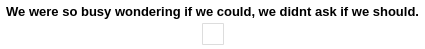

In [7]:
image_pd = pd.DataFrame({
    "color" : [img_data],
})

img_chart = alt.Chart(image_pd).mark_square(size=3, opacity=1).encode(
    color=alt.Color('color', scale=None),
).properties(
    title='We were so busy wondering if we could, we didnt ask if we should.'
)
img_chart

In [8]:
img_data = np.array(img_data)
image_pd = pd.DataFrame({
    'x': img_data[:,0],
    'y': img_data[:,1],
    "color" : img_data[:,2],
})

img_chart = alt.Chart(image_pd).mark_square(size=3, opacity=1).encode(
    x="x:Q",
    y="y:Q",
    color=alt.Color('color', scale=None),
).properties(
    title='We were so busy wondering if we could, we didnt ask if we should.'
)
img_chart

In [9]:
x_size = 12
y_size = 12
down_sized = np.array([cv2.resize(image, (x_size, y_size), interpolation=cv2.INTER_AREA) for image in images])

## file_to_open = "rrt_bad_data.pickle"
file_to_open = "rrt_good_data.pickle"
with open(file_to_open , "rb") as pickle_file:
    log_data = pickle.load(pickle_file)

In [10]:
log_data.keys()

dict_keys(['steps', 'rrt_expansion', 'state_switch_iteration_counts', 'steps_per_iteration', 'x_y_level', 'all_embeddings', 'rrt_embeddings', 'all_possibilities_len', 'end_time', 'all_explore_counts', 'all_distances', 'algorithm', 'game_name', 'movie_name', 'bbox_sum', 'nuc_norm'])

In [11]:
all_embeddings = np.array(log_data["rrt_embeddings"])[:,0:16]
all_explore_counts = np.array(log_data["all_explore_counts"])
all_distances = np.array(log_data["all_distances"])


In [12]:
all_embeddings.shape

(290, 16)

In [13]:
def get_distance(em_obs, goal):
    return np.linalg.norm(em_obs - goal)

def get_random_goal(obs, max_val, min_val):

    # Returns an array.
    # Conceptually what we wanted
    # np.random.uniform(size=obs.shape, low=min_val, high=max_val)

    # Returns a single number which is broadcasted ends up being an array of the single number.
    # Seems to work better, probably due to picking things on the fringes.
    # np.random.uniform(low=min_val, high=max_val)
    return np.random.uniform(size=obs.shape, low=min_val, high=max_val)

In [14]:
max_embedding_val = np.array(all_embeddings[0])
min_embedding_val = np.array(all_embeddings[0])

random_goal = get_random_goal(obs=all_embeddings[-1], min_val=min_embedding_val, max_val=max_embedding_val)

shape = all_embeddings.shape[0]
# shape = 100

explore_counts = np.zeros(shape, dtype=np.float64)
z_explore_counts = np.zeros((shape , shape), dtype=np.float64)
z_normalized = np.zeros((shape , shape), dtype=np.float64)

z_distances = np.zeros((shape , shape), dtype=np.float64)
z_distances_reverse = np.zeros((shape , shape), dtype=np.float64)
z_distances_normalized = np.zeros((shape , shape), dtype=np.float64)

for i in range(1, shape): #len(all_embeddings)):
    list_of_distances = np.array(all_distances[i-1])
    selected_index = np.argmin(list_of_distances)
    explore_counts[selected_index] += 1
    z_normalized[i] += normalize([explore_counts], norm="l2")[0]

    # Get Distances
    # Subtract the Minimum
    # Normalize the rest
    reversed_processed_z = max(list_of_distances - min(list_of_distances)) - (list_of_distances - min(list_of_distances))
    z_distances_reverse[i] += np.pad(reversed_processed_z, (0, z_distances_reverse.shape[1] - reversed_processed_z.shape[0]), 'constant')

    processed_z = list_of_distances
    z_distances[i] += np.pad(processed_z , (0, z_distances.shape[1] - processed_z.shape[0]), 'constant')

    norm_processed_z = 1 - normalize([list_of_distances - min(list_of_distances)], norm="l1")[0]
    z_distances_normalized[i] += normalize([np.pad(norm_processed_z, (0, z_distances_normalized.shape[1] - norm_processed_z.shape[0]), 'constant')], norm="l1")[0]

    z_explore_counts[i] += explore_counts

    np.maximum(max_embedding_val, all_embeddings[i], out=max_embedding_val)
    np.minimum(min_embedding_val, all_embeddings[i], out=min_embedding_val)
    
indexes = np.arange(len(explore_counts))
urls = [f"http://batuaytemiz.com/rrt/Expansion_{index}.png" for index in indexes]

In [15]:

number_of_images = 50

down_sized_altair = []
img_data = []
img_shape = down_sized[0].shape
for index, image in enumerate(down_sized[0:number_of_images]):
    for y in range(img_shape[0]):
        for x in range(img_shape[1]):
            pixel_color = image[y][x]/255
#             img_data.append((index, x+.5, img_shape[0]-y-.5, rgb2hex(pixel_color)))
            img_data.append((index, x, img_shape[0]-y, rgb2hex(pixel_color)))
    down_sized_altair.append(img_data)
    
down_sized_altair = np.array(down_sized_altair)
down_sized_altair[:,:,0].shape

(50, 7200)

In [16]:
images_df = pd.DataFrame({
    "id": down_sized_altair[:,:,0].flatten().astype(np.int16),
    'x': down_sized_altair[:,:,1].flatten().astype(np.int8),
    'y': down_sized_altair[:,:,2].flatten().astype(np.int8),
    "color" : down_sized_altair[:,:,3].flatten(),
})

del down_sized_altair
del down_sized
del images

bar_chart_df = pd.DataFrame({
    "id": np.arange(len(explore_counts[0:number_of_images])),
    "explore_counts" : explore_counts[0:number_of_images],
})

In [17]:
bar_chart_df[:5]

id  explore_counts
0   0             2.0
1   1             9.0
2   2             1.0
3   3             0.0
4   4             0.0

In [18]:
images_df[:5]

id  x   y    color
0   0  0  12  #000000
1   0  1  12  #000000
2   0  2  12  #000000
3   0  3  12  #000000
4   0  4  12  #000000

In [19]:
images_df["id"] = images_df["id"].astype(np.int16)
bar_chart_df["id"] = bar_chart_df["id"].astype(np.int16)
combined_data = pd.merge(images_df, bar_chart_df, on='id')

del images_df
del bar_chart_df

combined_data["explore_counts"] = combined_data["explore_counts"].astype(np.int16)

In [20]:
# Prune the data.
print(combined_data.shape)
combined_data = combined_data.loc[combined_data['explore_counts'] > 0]
print(combined_data.shape)

(360000, 5)
(216000, 5)


In [24]:
clicker = alt.selection_single(empty="none", fields=['id'])

chart = alt.Chart(combined_data).mark_bar().encode(
    x='id:Q',
    y='explore_counts:Q',
    tooltip=["id"]
).add_selection(
    clicker
)

img_chart = alt.Chart(combined_data).mark_square(size=600, opacity=.5).encode(
    x="x:Q",
    y="y:Q",
    color=alt.Color('color', scale=None),
    tooltip=["id"]
).transform_filter(
    clicker
).properties(width=280)

chart | img_chart 

In [22]:
clicker = alt.selection_single(empty="none", fields=['id'])

bar_chart_url_df = pd.DataFrame({
    "id": np.arange(len(explore_counts)),
    "explore_counts" : explore_counts,
    "urls":urls
})

url_chart = alt.Chart(bar_chart_url_df).mark_bar().encode(
    x='id:Q',
    y='explore_counts:Q',
    href="urls:N",
    tooltip=["id"]
).add_selection(
    clicker
).properties(
    title='Explore Count Openable by Image'
)

url_chart

# RRT Orthants

In [105]:
mean_embeddings = np.mean(all_embeddings, axis=0) 
mean_embeddings_ds = pd.Series(mean_embeddings)

mean_embeddings_ds.describe()

count     16.000000
mean      76.192619
std      130.980316
min       -0.884772
25%        1.364304
50%       15.494069
75%       91.137587
max      487.043488
dtype: float64

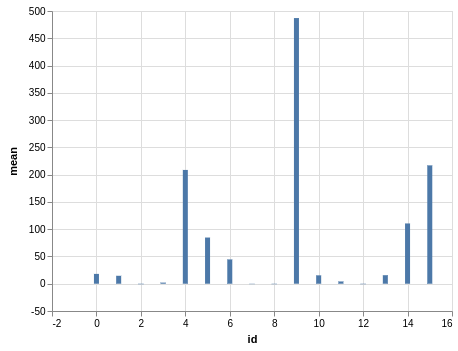

In [106]:
mean_embeddings_df = pd.DataFrame({
    "id": np.arange(len(mean_embeddings)),
    "mean":mean_embeddings
})

mean_chart = alt.Chart(mean_embeddings_df).mark_bar().encode(
    x='id:Q',
    y="mean"
)
mean_chart

In [107]:
id_to_orthant = dict()
orthants = []
for index, embedding in enumerate(all_embeddings):
    orthant = [
        1 if dimension_val > mean_val else 0 
        for dimension_val, mean_val
        in zip(embedding, mean_embeddings)
    ]
    id_to_orthant[index] = orthant 
    orthants.append(orthant)

orthants = np.array(orthants) 

In [108]:
(all_embeddings > mean_embeddings).shape

(290, 16)

In [110]:
orthants_distribution = dict()
# np.unique
for orthant in orthants:
    hash_tuple = tuple(orthant)
    orthants_distribution[hash_tuple] =  orthants_distribution.get(hash_tuple, 0) + 1

orthant_dist = list(orthants_distribution.values())
print("The distribution over orthants", orthant_dist)
distribution_fd = pd.DataFrame({
    "index": np.arange(len(orthant_dist)),
    "counts":orthant_dist
})

sorted_count = np.array(sorted(orthant_dist, reverse=True))
print("The non-one values", sorted_count[sorted_count > 1])

most_common_orthant = [key for key, value in orthants_distribution.items() if value == max(orthant_dist)][0]
second_most_common_orthant = [key for key, value in orthants_distribution.items() if value == sorted_count[1]][0]
third_most_common_orthant = [key for key, value in reversed(list(orthants_distribution.items())) if value  == sorted_count[2]][0]
fourth_most_common_orthant = [key for key, value in orthants_distribution.items() if value == sorted_count[3]][0]
fifth_most_common_orthant = [key for key, value in orthants_distribution.items() if value  == sorted_count[4]][0]

# Throw away some dimensions in this
# Combine certain dimension.

The distribution over orthants [34, 1, 5, 6, 6, 4, 1, 7, 10, 3, 2, 2, 1, 1, 2, 5, 5, 2, 1, 2, 3, 5, 1, 2, 2, 5, 11, 2, 3, 3, 2, 1, 1, 5, 2, 1, 22, 5, 1, 1, 2, 3, 5, 2, 1, 3, 2, 9, 3, 1, 5, 1, 1, 1, 2, 2, 1, 1, 1, 9, 6, 1, 1, 1, 7, 1, 2, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1]
The non-one values [34 22 11 10  9  9  7  7  7  6  6  6  5  5  5  5  5  5  5  5  5  4  3  3
  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]


34


In [116]:
for index, count in enumerate(sorted_count[sorted_count > 1]):
    most_common_orthant = [key for key, value in orthants_distribution.items() if value == count][0]
    indexes_of_most_common_orthant = [key for key, value in id_to_orthant.items() if value == list(most_common_orthant)]
    folder_name = f"{index}th_most_common"
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    for image_count in indexes_of_most_common_orthant:
        source = f"/home/batu/Desktop/Retro-Spring/Retro_Workspace/Analysis/RRT_Insights/GoodImages/Expansion_{image_count}.png"
        destination = f"/home/batu/Desktop/Retro-Spring/Retro_Workspace/Analysis/RRT_Insights/{folder_name}/Expansion_{image_count}.png"
        copyfile(source, destination)
    

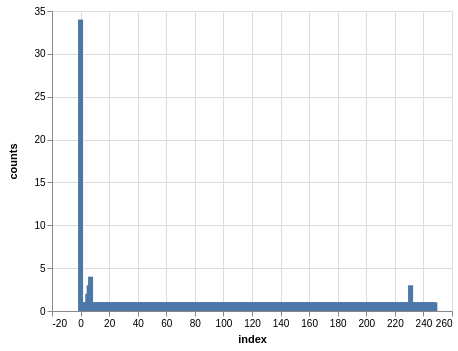

In [199]:
count_chart = alt.Chart(distribution_fd).mark_bar().encode(
    x='index:Q',
    y="counts",
)
count_chart

In [220]:
indexes_of_most_common_orthant = [key for key, value in id_to_orthant.items() if value == list(most_reached_destination)]
folder_name = "most_reached"
if not os.path.exists(folder_name):
    os.mkdir(folder_name)
    
for image_count in indexes_of_most_common_orthant:
    source = f"/home/batu/Desktop/Retro-Spring/Retro_Workspace/Analysis/RRT_Insights/GoodImages/Expansion_{image_count}.png"
    destination = f"/home/batu/Desktop/Retro-Spring/Retro_Workspace/Analysis/RRT_Insights/{folder_name}/Expansion_{image_count}.png"
    copyfile(source, destination)
    

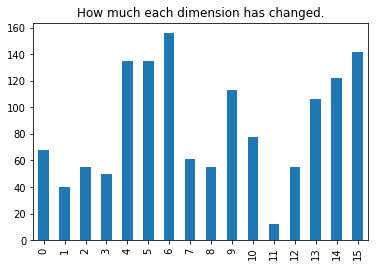

In [118]:
orthants_flow = dict()
change_array = np.zeros(shape=(16,))
abs_change_array = np.zeros(shape=(16,))

for target, destination in zip(orthants, orthants[1:]):
    
    hash_tuple = tuple([tuple(target), tuple(destination)])
    change = target - destination
    abs_change_array += np.abs(change)
    change_array += change
    orthants_flow[hash_tuple] =  orthants_flow.get(hash_tuple, 0) + 1
    
pd.Series(abs_change_array).plot(kind="bar", title="How much each dimension has changed.")

In [119]:
pd.Series(sorted(abs_change_array, reverse=True)).plot(kind="bar", title="How much each dimension has changed [SORTED].")

In [122]:
print("How much each individual element has changed.", change_array) 
# Probably due to how averages work out the delta is the identical to the end. ???

How much each individual element has changed. [ 0.  0.  1.  0. -1. -1.  0.  1.  1. -1.  0.  0.  1.  0.  0.  0.]


In [123]:
print("The number of times a target_destination happened", orthants_flow.values())
most_leaved_target, most_reached_destination = [key for key, value in orthants_flow.items() if value == 6][0]
most_leaved_target == most_reached_destination
print("Most leaved target and destination is the same:", most_leaved_target == most_reached_destination)
print()

The number of times a target_destination happened dict_values([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1])
Most leaved target and destination is the same: True



In [145]:
lookup = {e: i for (i,e) in enumerate(set(map(tuple, orthants)))}
heat = np.zeros((len(lookup), len(lookup)))
for a,b in zip(orthants[:-1],orthants[1:]):
    heat[lookup[tuple(a)],lookup[tuple(b)]] += 1
plt.imshow(heat)
plt.colorbar()

In [124]:
for target, destination in zip(orthants, orthants[1:]):
    hash_tuple = tuple([tuple(target), tuple(destination)])
    change = target - destination
    abs_change_array += np.abs(change)
    change_array += change
    orthants_flow[hash_tuple] =  orthants_flow.get(hash_tuple, 0) + 1

{1, 2, 3, 6}

In [226]:
"Six times black started black ended."

'Six times black started black ended.'

## OLD STUFF BELOW

In [ ]:
base_brightness_amount = 0.05

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(shape), range(shape))
# Convert this grid to columnar data expected by Altair
# print(np.max(z_explore_counts.ravel()))
source = pd.DataFrame({'Possible_States': x.ravel(),
                     'RRT_Step': y.ravel(),
#                      'Exploration Count': [ element + base_brightness_amount if element > 0 else 0 for element in z_normalized.ravel()]})
                     'Exploration Count': z_explore_counts.ravel()})

chart = alt.Chart(source).mark_rect().encode(
    x='RRT_Step:O',
    y='Possible_States:O',
#     color=alt.Color('Exploration Count:Q', scale=alt.Scale())
    color=alt.Color('Exploration Count:Q', scale=alt.Scale(scheme='greys')),
    tooltip=list(source.keys())
).properties(
    title='Exploration Count'
)
chart.properties(width=size, height=size)


In [ ]:
base_brightness_amount = 0.05

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(shape), range(shape))
# Convert this grid to columnar data expected by Altair
# print(np.max(z_explore_counts.ravel()))
source = pd.DataFrame({'Possible_States': x.ravel(),
                     'RRT_Step': y.ravel(),
#                      'Exploration Count': [ element + base_brightness_amount if element > 0 else 0 for element in z_normalized.ravel()]})
                     'Exploration Count': z_normalized.ravel()})

chart = alt.Chart(source).mark_rect().encode(
    x='RRT_Step:O',
    y='Possible_States:O',
#     color=alt.Color('Exploration Count:Q', scale=alt.Scale())
    color=alt.Color('Exploration Count:Q', scale=alt.Scale(scheme='greys')),
    tooltip=list(source.keys())
).properties(
    title='Exploration Count Normalized - (Intensity goes down if not selected anymore)'
).interactive()
chart.properties(width=size, height=size)


In [ ]:
base_brightness_amount = 0.05

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(shape), range(shape))
# Convert this grid to columnar data expected by Altair
# print(np.max(z_explore_counts.ravel()))
source = pd.DataFrame({'Possible_States': x.ravel(),
                     'RRT_Step': y.ravel(),
#                      'Exploration Count': [ element + base_brightness_amount if element > 0 else 0 for element in z_normalized.ravel()]})
                     'Distance': z_distances.ravel()})

chart = alt.Chart(source).mark_rect().encode(
    x='RRT_Step:O',
    y='Possible_States:O',
#     color=alt.Color('Exploration Count:Q', scale=alt.Scale())
    color=alt.Color('Distance:Q', scale=alt.Scale(scheme='greys')),
    tooltip=list(source.keys())
    
).properties(
    title='Distances (DARKER = FARTHER)'
).interactive()
chart.properties(width=size, height=size)

In [ ]:
base_brightness_amount = 0.05

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(shape), range(shape))
# Convert this grid to columnar data expected by Altair
# print(np.max(z_explore_counts.ravel()))
source = pd.DataFrame({'Possible_States': x.ravel(),
                     'RRT_Step': y.ravel(),
#                      'Exploration Count': [ element + base_brightness_amount if element > 0 else 0 for element in z_normalized.ravel()]})
                     'Distance Reversed': z_distances_reverse.ravel()})

chart = alt.Chart(source).mark_rect().encode(
    x='RRT_Step:O',
    y='Possible_States:O',
#     color=alt.Color('Exploration Count:Q', scale=alt.Scale())
    color=alt.Color('Distance Reversed:Q', scale=alt.Scale(scheme='greys')),
    tooltip=list(source.keys())
).properties(
    title='Distance Reversed And Processed (DARKER = CLOSER)'
).interactive()
chart.properties(width=size, height=size)

In [ ]:
base_brightness_amount = 0.05

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(shape), range(shape))
# Convert this grid to columnar data expected by Altair
# print(np.max(z_explore_counts.ravel()))
source = pd.DataFrame({'Possible_States': x.ravel(),
                     'RRT_Step': y.ravel(),
#                      'Exploration Count': [ element + base_brightness_amount if element > 0 else 0 for element in z_normalized.ravel()]})
                     'Norm Dist': z_distances_normalized.ravel()})

chart = alt.Chart(source).mark_rect().encode(
    x='RRT_Step:O',
    y='Possible_States:O',
#     color=alt.Color('Exploration Count:Q', scale=alt.Scale())
    color=alt.Color('Norm Dist:Q', scale=alt.Scale(scheme='greys')),
    tooltip=list(source.keys())
    
).properties(
    title='Distances Processed and Normalized (DARKER = CLOSER)'
).interactive()
chart.properties(width=size, height=size)

In [ ]:
source_scatter = pd.DataFrame({'Possible_States': ,
                     'RRT_Step': y.ravel(),
#                      'Exploration Count': [ element + base_brightness_amount if element > 0 else 0 for element in z_normalized.ravel()]})
                     'Distance Reversed': z_distances_reverse.ravel()})

chart = alt.Chart(source).mark_rect().encode(
    x='RRT_Step:O',
    y='Possible_States:O',
#     color=alt.Color('Exploration Count:Q', scale=alt.Scale())
    color=alt.Color('Distance Reversed:Q', scale=alt.Scale(scheme='greys')),
    tooltip=list(source.keys())
).properties(
    title='Distance Reversed And Processed (DARKER = CLOSER)'
).interactive()
chart.properties(width=size, height=size)

In [ ]:
first_dim = 15
second_dim = 125

zeroth_element = all_embeddings[:,first_dim]
first_element = all_embeddings[:,second_dim]

source_scatter = pd.DataFrame({'zero': zeroth_element,
                               "first": first_element,
                               "count": explore_counts})

chart = alt.Chart(source_scatter).mark_circle().encode(
    x='zero',
    y='first',
    size="count",
    tooltip=list(source_scatter.keys())
).interactive(
).properties(
title="ACTUALLY Human")
chart